In [4]:
# 1. 패키지 임포트
import tensorflow as tf 
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential  # 모델을 구성하기 위한 모듈
from tensorflow.keras.layers import Activation,Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout  # CNN, 완전 연결계층을 구성하기 위한 모듈
from tensorflow.keras.utils import to_categorical # one encoding 하는 모듈
import numpy as np

# 2. vgg 신경망 설계도
from  tensorflow.keras.applications import VGG16
vgg16 = VGG16(weights = 'imagenet', input_shape =(32, 32, 3), include_top=False) # include_top: 완전 연결 계층 부분 포함 X -> 직접 구현

In [2]:
# 신경망을 동결
for  layer  in  vgg16.layers[:]:
   layer.trainable = False   # False 는 동결

# 신경망을 동결 해제
# for layer in vgg16.layers[:]:
#     layer.trainable = True   # True 는 동결 해제 (default) -> 새로운 데이터를 넣어서 학습할 수 있음
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [3]:
# 3. cifar10 데이터 로드
tf.random.set_seed(777)

(x_train, y_train), (x_test, y_test) = cifar10.load_data() # 3차원 

x_train = x_train.reshape(-1, 32, 32, 3)  # 4차원으로 변환
x_test = x_test.reshape(-1, 32, 32, 3)
print(x_train.shape) # (50000, 32, 32, 3)
print(x_test.shape)  # (10000, 32, 32, 3)

170498071/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [5]:
# 4. 정규화 진행  
x_train = x_train / 255 
x_test = x_test / 255

# 5. label one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [6]:
# 6. 모델 생성
model = Sequential()
model.add(vgg16)  # vgg16 모델 사용

# 완전 연결 계층 직접 구현
model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Activation('relu'))
model.add(Dense(10, activation='softmax')) # 원래는 1000개지만 10개만 분류함
model.summary()


# 7. 모델 설정 (경사하강법, 오차 함수)
model.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 activation (Activation)     (None, 256)               0         
                                                        

In [7]:
from tensorflow.keras.callbacks import EarlyStopping 

'''
# early stopping 추가
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_acc"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

#검증 데이터의 정확도가 80% 넘으면 조기중단하게 설정
callbacks  = MyThresholdCallback(threshold=0.8)
'''

#8. 모델 훈련
history = model.fit(x_train, y_train,
                    epochs = 100,
                    batch_size = 100,
                    validation_data=(x_test, y_test))
                    #, callbacks = callbacks )

Epoch 1/100
500/500 [==============================] - 47s 59ms/step - loss: 1.9421 - acc: 0.2457 - val_loss: 1.9902 - val_acc: 0.3024
Epoch 2/100
500/500 [==============================] - 27s 54ms/step - loss: 1.3930 - acc: 0.4521 - val_loss: 2.9426 - val_acc: 0.2382
Epoch 3/100
500/500 [==============================] - 28s 55ms/step - loss: 1.1694 - acc: 0.5499 - val_loss: 1.1249 - val_acc: 0.5787
Epoch 4/100
500/500 [==============================] - 28s 56ms/step - loss: 1.0233 - acc: 0.6135 - val_loss: 1.6413 - val_acc: 0.4449
Epoch 5/100
500/500 [==============================] - 28s 56ms/step - loss: 0.9038 - acc: 0.6621 - val_loss: 0.9391 - val_acc: 0.6710
Epoch 6/100
500/500 [==============================] - 27s 53ms/step - loss: 0.7867 - acc: 0.7111 - val_loss: 0.9811 - val_acc: 0.6704
Epoch 7/100
500/500 [==============================] - 28s 56ms/step - loss: 0.6589 - acc: 0.7586 - val_loss: 0.9840 - val_acc: 0.6662
Epoch 8/100
500/500 [==============================] - 

In [8]:
# 9.모델 평가
model.evaluate(x_test, y_test)

train_acc_list=history.history['acc']
train_acc_list

test_acc_list=history.history['val_acc']
test_acc_list

313/313 [==============================] - 4s 9ms/step - loss: 1.1618 - acc: 0.8221


[0.30239999294281006,
 0.23819999396800995,
 0.5787000060081482,
 0.4449000060558319,
 0.6710000038146973,
 0.6704000234603882,
 0.6661999821662903,
 0.7182999849319458,
 0.7437999844551086,
 0.7391999959945679,
 0.7835999727249146,
 0.7721999883651733,
 0.7746000289916992,
 0.7943000197410583,
 0.7666000127792358,
 0.7925999760627747,
 0.7818999886512756,
 0.7821999788284302,
 0.7804999947547913,
 0.795799970626831,
 0.8062999844551086,
 0.7907000184059143,
 0.8080000281333923,
 0.7950999736785889,
 0.8075000047683716,
 0.7961999773979187,
 0.7892000079154968,
 0.8087999820709229,
 0.7968999743461609,
 0.7978000044822693,
 0.8016999959945679,
 0.8084999918937683,
 0.7882000207901001,
 0.8115000128746033,
 0.8070999979972839,
 0.8116000294685364,
 0.8123000264167786,
 0.8147000074386597,
 0.8090000152587891,
 0.8041999936103821,
 0.8016999959945679,
 0.7971000075340271,
 0.8029999732971191,
 0.8101999759674072,
 0.8113999962806702,
 0.8015999794006348,
 0.8126000165939331,
 0.808300018

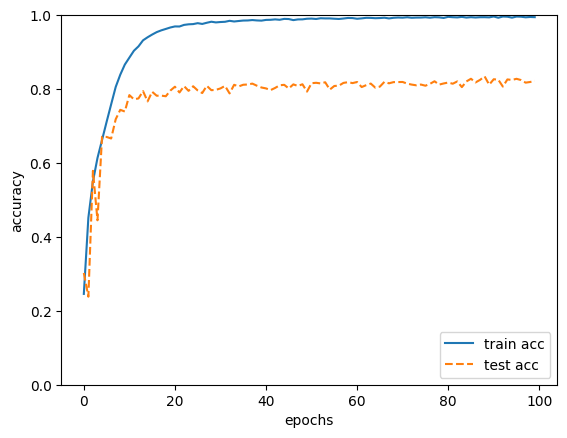

In [10]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()